# Welcome to a Sample eNVM Exploration!

This page will serve as a tutorial for NVMExplorer users to learn what to expect from the output of the framework. It can also serve as a learning tool to guide exploration of example data, as well as adapt this as a resource to make your own explorations with generated data.

This exploration uses the python data science library pandas and matplotlib to make different visualizations using example summary csv outputs from NVMExplorer design studies. It also uses jupyter notebook interactive widgets to give the user more flexibility in filtering data and refining their design space exploration.

**Please run the cells in order** as some cells depend on helper methods defined earlier.

## Loading Your Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, IntRangeSlider
import ipywidgets as widgets
from math import log10, floor, ceil
import re
import copy

#creates a database from the different data files for the different memory cells

SRAMdf = pd.read_csv('SRAM_1BPC-combined.csv')
STTdf = pd.read_csv('STT_1BPC-combined.csv')
RRAMdf = pd.read_csv('RRAM_1BPC-combined.csv')
FeFETdf = pd.read_csv('FeFET_1BPC-combined.csv')
PCMdf = pd.read_csv('PCM_1BPC-combined.csv')

# if you would like to include endurance data, else ignore.
endurancedf = pd.read_csv('2016-2020_EnduranceSummary.csv')

#makes a list of all the databases
dfs = [SRAMdf, STTdf, RRAMdf, FeFETdf, PCMdf]

#makes a large database with all combined data
df = pd.concat(dfs)

df.columns

Index(['MemCellType', 'CellArea (F^2)', 'CellAspectRatio', 'AccessType',
       'AccessCMOSWidth (F)', 'SRAMCellNMOSWidth (F)', 'SRAMCellPMOSWidth (F)',
       'ReadMode', 'ReadVoltage (V)', 'MinSenseVoltage (mV)', 'Stitching',
       'MemoryCellInputFile', 'DesignTarget', 'DeviceRoadmap', 'LocalWireType',
       'LocalWireRepeaterType', 'LocalWireUseLowSwing', 'GlobalWireType',
       'GlobalWireRepeaterType', 'GlobalWireUseLowSwing', 'Routing',
       'InternalSensing', 'Temperature (K)', 'BufferDesignOptimization',
       'ProcessNode', 'OptimizationTarget', 'WordWidth (bit)', 'Capacity (MB)',
       'Benchmark Name', 'Read Accesses', 'Write Accesses',
       'Total Dynamic Read Power (mW)', 'Total Dynamic Write Power (mW)',
       'Total Power', 'Total Dynamic Read Energy (mJ)',
       'Total Dynamic Write Energy (mJ)', 'Total Read Latency (ms)',
       'Total Write Latency (ms)', 'Read BW Util', 'Write BW Util',
       'Area (mm^2)', 'Area Efficiency (percent)', 'Read Latency (ns)

Printed above are all of the columns extracted from NVMExplorer csv outputs, which include all of the configuration parameters and simulated metrics that can be selected, analyzed, filtered, visualized, or used in further post-processing computations.
We will explore some of the most important data fields above to answer some questions about the performance of the different memory cells.  In this exploration, we leverage a default cell configuration for each of several NVM cell types and compare array-level and application-level metrics, as described further below.

## Graphing the Data

The data here also evalutes different traffic patterns for the different types of embedded non-volatile memory. In other words, the performance and power of memory arrays comprised of distinct cell types are simulated under different proportions of reads and writes. The memory technologies being considered in this exploration are MRAM (STT), memristors (RRAM), FeFET, PCRAM (PCM), and, as a reference point for current on-chip memory capabilities, SRAM. All of the arrays in this expreiment have a capacity of 1MB.

First off, we will create some methods that will be useful for plotting the graphs and for user interactivity.

In [2]:

# Makes a list of the cells that are in the data.
paths = list()
cells = list()

# this is the dict of CURRENT frames that the plots loop over to read data
labels = list()
frames = list()

#this method gets all the cel config paths and adds them to a paths list, it also gets a substring of the cell
#and makes another string.
def getCells():
    for path in df['MemoryCellInputFile'].unique():
        if isinstance(path, str):
            match = re.search(' data/cell_cfgs/(.*)\.cell$', path)
            if match:
                paths.append(match.group())
                cells.append(match.group(1))
getCells()

#makes the widgets for each cell configuration in the file and the dictionary with ALL of the cell configurations
cell_frames = {}
widget_dict = {}
dfs.clear()

i = 0

#this loop feeds a dictionary with the different frames based on the cell config paths given by the data
#it also makes the necessary widgets based on this data
for path in paths:
    myFrame = pd.DataFrame(columns=df.columns)
    myFrame = pd.concat([myFrame, df[(df['MemoryCellInputFile'] == path)]])
    cell_frames[path] = myFrame
    dfs.append(myFrame)
    
    widget_dict[path] = widgets.Checkbox(value=True, description=cells[i])
    i += 1

#this function looks at the memories the user toggles on and decides which will be in the list that plt will loop over
def frameList(**kwargs):
    
    labels.clear()
    frames.clear()

    i = 0
    for key, value in kwargs.items():
        if value:
            frames.append(key)
            labels.append(cells[i])
        i += 1
    
        
    return frames

# this method gets a number and then outputs the exponent if it were written in scientific method
def find_exp(number) -> float:
    
    base10 = log10(abs(number))
  
    return base10

# these methods find the minimum and maximum of all the rows in a certain column
def min_(column_name) -> int:
    
    # it makes a copy of the full dataframe with indexes and data
    df1 = df.copy(deep=True)
    
    # drops the rows where the value is 0 from the new df so it is not included in the minimum function
    # this is because we use the log10 function so that we get a power of ten with miniscule numbers
    # so we want to get -5 for 0.00001 and not 0.
    df1.drop(df1[(df1[column_name] == 0)].index, inplace=True)
    
    # finds the exponent if it were in scientific notation, ignores non numeric values
    exp = find_exp(df1[column_name].min(numeric_only=True))
    
    #takes the floor to give you some space between the border of the graph and the minimum data point.
    _min = floor(exp)
    
    # similarily, if the original number is too close to the floored value, we make the range one lower.
    if exp - _min < 0.3:
        _min -= 1
    return _min

def max_(column_name) -> int:
    exp = find_exp(df[column_name].max())
    _max = ceil(exp)
    if _max - exp < 0.3:
        _max +=1
    return _max

# turns the linear scale of the user input into a logarithmic scale by using the input as a power of ten
def findRange(_min, _max):
    _range = (10 ** _min, 10 ** _max)
    return _range

colors = ['cornflowerblue', 'firebrick', 'gold', 'forestgreen', 'mediumpurple']
    

# ============================================================
### Chapter 1: Per-Technology Array Characteristics for a Single Access

To begin, we will start looking at the array characteristics of each type of cell compared to each other, and the statistics regarding a single read or write access at a time.

Evidently, a good memory technology is only useful if we can fit it in our computers, so knowing their areas is pretty useful...

In [3]:

def graph(TURN_ON, **kwargs):
 
    # these turning on buttons appear in every graph, make sure to turn each graph off when you stop using it 
    # or turn them on only when using them as, especially for the bar charts, having them on affects the latency
    # of all the toggles
    if TURN_ON:
        # updates the frames list so to include only the technologies we want to show
        myFrames = frameList(**kwargs)
    
        # specifies titles, labels and scales
        plt.title("Area (mm^2) of each Memory Cell")
        plt.xlabel("Memory Cell Type")
        plt.ylabel("Area (mm^2)")
    
        # defines the maximum range of the y axis
        plt.ylim(0, 1)
    
        # makes a bar chart of the memory cell type and our its area
        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Area (mm^2)'], color = colors[i])
            i += 1
        
        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()
    
    return 


# the interact function defines the buttons that the user will be able to toggle basee on the customized dict made earlier.
#It also signals that these toggles go as inputs to the function graph
interact(graph, TURN_ON=True, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='SRAM_defa…

<function __main__.graph(TURN_ON, **kwargs)>

The chart above shows us how all of the eNVM technologies achieve smaller area than the commonly used SRAM by almost a factor of 3. 
The area of the FeFET array is also significantly smaller than the other technologies.
As all of the cells considered have a capacity of 1MB, this comparison reflects the potential for increased storage density across eNVM technologies.

In [4]:
# makes a new column in the dataframe for the density by doing operations on two already existing columns
for frame in cell_frames.values():
    frame['Density(MB/mm^2)'] = frame['Capacity (MB)'] / frame['Area (mm^2)']


def graph(TURN_ON, **kwargs):
    
    if TURN_ON:
        myFrames = frameList(**kwargs)

        plt.title("The Density of each Memory Cell")
        plt.xlabel("Memory Cell Type")
        plt.ylabel("Density of Memory Cell (MB/mm^2)")
        
        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Density(MB/mm^2)'], color = colors[i])
            i += 1

        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()
    
    return 

interact(graph, TURN_ON=True, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='SRAM_defa…

<function __main__.graph(TURN_ON, **kwargs)>

Evidently, FeFET achieves highest density among these solutions.

A related metric that we may examine is the area efficiency of each memory array:

In [5]:


def graph(TURN_ON, **kwargs):
    
    if TURN_ON:
        myFrames = frameList(**kwargs)

        plt.title("Storage Density")
        plt.xlabel("Memory Cell Type")
        plt.ylabel("Area Efficiency (%)")

        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Area Efficiency (percent)'], color = colors[i])
            i += 1
        
        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()

    return 

interact(graph,TURN_ON=True, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='SRAM_defa…

<function __main__.graph(TURN_ON, **kwargs)>

Here, area efficiency refers to what proportion of a memory array is actually comprised of memory cells. The rest of it is comprised of peripheral circuitry.

Once again, FeFET has the highest area efficiency, but this time SRAM, MRAM and the memristor are only slightly below it. However, PCRAM exhibits an area efficiency of just over 40%.  This relationship will change significantly according to our array optimization target and array capacity.

Below is the energy required to read a single bit from each type of memory cell.
The WordWidth refers to the amount of bits that are passed in and out of the array per each access, so this metric is the result of dividing the total read energy per access by the word width.

In [6]:
for dataFrame in cell_frames.values():
    dataFrame['Read Energy / bit (pJ)'] = dataFrame['Read Energy (pJ)'] / dataFrame['WordWidth (bit)']

def graph(TURN_ON, **kwargs):
    
    if TURN_ON:
        
        myFrames = frameList(**kwargs)

        plt.title("The Read Energy per Bit for each Cell Type")
        plt.xlabel("Memory Cell Type")
        plt.ylabel("Read Energy / bit (pJ)")
        plt.ylim(0, 0.1)

        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Read Energy / bit (pJ)'], color = colors[i])
            i += 1
        
        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()
    
    return 

interact(graph, TURN_ON=True, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='SRAM_defa…

<function __main__.graph(TURN_ON, **kwargs)>

As we can see, FeFET is the most efficient eNVM of these configurations in terms of energy required to read a single bit (below 0.02pJ). SRAM is also not very costly, and then most other technologies require more than triple the energy then FeFET does, at roughly 0.06pJ.  For eNVM technlogies, we expect an advantage with respect to leakage power over volatile technologies, even when dynamic energy per access is comparable or worse than SRAM.

Answering the same question for write energy per bit:

In [7]:
for dataFrame in cell_frames.values():
    dataFrame['Write Energy / bit (pJ)'] = dataFrame['Write Energy (pJ)'] / dataFrame['WordWidth (bit)']

def graph(TURN_ON, **kwargs):
  
    if TURN_ON:
    
        myFrames = frameList(**kwargs)

        plt.title("The Write Energy per Bit for each Cell Type")
        plt.xlabel("Memory Cell Type")
        plt.ylabel("Write Energy / bit (pJ)")
        plt.ylim(0, 1.5)

        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Write Energy / bit (pJ)'], color = colors[i])
            i += 1
        
        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()

    return 

interact(graph, TURN_ON=True, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='SRAM_defa…

<function __main__.graph(TURN_ON, **kwargs)>

Again, only one eNVM seems to need less energy than the usual SRAM, being PCRAM just below 0.25pJ. FeFET is a close second, although it already seems slightly more costly than SRAM, and the other technologies are way more costly, MRAM being the worse with over 1pJ per bit written.


Another statistic that we are going to look at to understand the differrent cell technologies is their leakage power. This refers to the energy that maintains the array or is 'leaked' per second while the array is powered. 

For some of these graphs, you will see that you have the option to show the y-axis both with a log and a linear scale based on the toggle buttons for improved clarity.

The graph is below:

In [8]:

def graph(TURN_ON, Y_Log_Scale, **kwargs):
    
    if TURN_ON:
        myFrames = frameList(**kwargs)

        plt.title("The Leakage Power of a Memory Cell against their Write Accesses")
        plt.xlabel("Write Accesses / s")
        plt.ylabel("Leakage Power (mW)")

        if Y_Log_Scale:
            plt.yscale("log", base=2)

            # these few statements make it so that the y axis shows in normal format rather than scientific notation
            ax = plt.gca()
            ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
            ax.yaxis.get_major_formatter().set_scientific(False)
            ax.yaxis.get_major_formatter().set_useOffset(False)
            
        i = 0
        for frame in myFrames:
            plt.bar(cell_frames[frame]['MemoryCellInputFile'], cell_frames[frame]['Leakage Power (mW)'], color = colors[i])
            i += 1
        
        currxticks, currxlabels = plt.xticks()
        plt.xticks(currxticks,labels,rotation=45)
        plt.show()

    return 

# now includes another toggle so that you can determine whether you want the y scale to be linear or logarithmic
interact(graph, TURN_ON=True, Y_Log_Scale = False, **widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=False, description='Y_Log_Sc…

<function __main__.graph(TURN_ON, Y_Log_Scale, **kwargs)>

This graphic illustrates that most eNVM technologies exhibit significantly lower leakage power than SRAM. An exception for these particularly configurations is PCRAM, which although it is still below SRAM by a couple mW, it requires more than 20mW while its counterparts are well below 5mW.

Lastly, another relevant aspect about each cell is its endurance, or life expetancy. This refers to how many cycles can a cell perform until it begins to possibly fail or give issues. Different cell designs and operating conditions incur a range of previously published endurance values per technology, so our data contains maximum and minimum values derived from previous publications, as documented in the NVMExplorer paper (HPCA '22). The following chart shows this range:

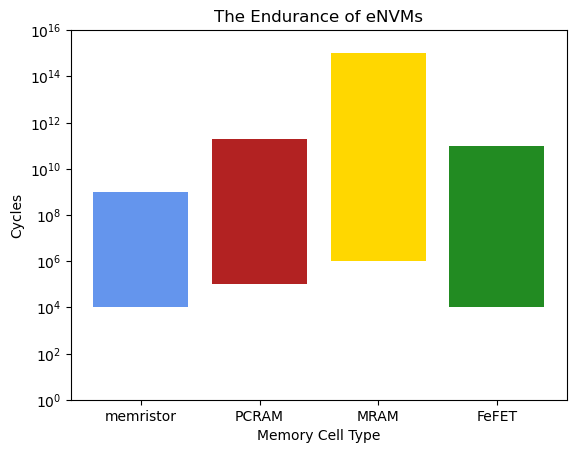

In [9]:
# Do not run this chunk if you do not have a specific endurance data set.

endurancedf.drop(endurancedf[(endurancedf['Memory Cell'] == 'SOT') | (endurancedf['Memory Cell'] == 'CTT') | (endurancedf['Memory Cell'] == 'eFlash')].index, inplace = True)

def graph():
    
    plt.title("The Endurance of eNVMs")
    plt.xlabel("Memory Cell Type")
    plt.ylabel("Cycles")
    plt.yscale("log")
    plt.ylim(1, 1e16)
    plt.bar(endurancedf['Memory Cell'], endurancedf['max'], color=colors, bottom = endurancedf['min'])
    plt.show()
    
    return 

graph()

As we can see, the range in these values is large, especially for MRAM. However, one conclusion we can make is that MRAM is the most reliable as it will start failing after more cycles than the other technologies, and that you are probably worse off with the memristor or a FeFET unless your system setting is solely read-intensive.

# ============================================================
### Chapter 2: Analyzing Array Performance under Realistic Memory Traffic Patterns

Now that we have a rough understanding of the properties of each array in isolation, we can move on to analyze how the arrays behave when a bunch of read and write accesses are made with different types of traffic patterns.

This first graph below displays the total memory power in mW against the amount of read accesses per second of work.

In [10]:
for dfr in dfs:
    # creates a new column in the current dataframe, by adding the Total Dynamic Read Power, the Total Dynamic
    # Write Power and the Leakage Power of each cell
    
    # now we create the new column before anything runs because the interact function needs it to evaluate the 
    # ranges of the sliders
    dfr['Total Mem Power'] = dfr['Total Dynamic Read Power (mW)'] + dfr['Total Dynamic Write Power (mW)'] + dfr['Leakage Power (mW)']

    
# have to update the big dataframe so that the min and max functions work
df = pd.concat(dfs)

def graph(TURN_ON, Y_Log_Scale, x_Range, y_Range, y_Range_log, **kwargs):
    
    if TURN_ON:
    
        # the find range method returns a tuple, so the first index contains the min and the second one contains the max
        xRange = findRange(x_Range[0], x_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Total Power of a Memory Cell against their Read Accesses")
        plt.xlabel("Read Accesses / s")
        plt.ylabel("Total Memory Power (mW)")
        plt.xscale("log")

        if Y_Log_Scale:
            plt.yscale("log")
            yRange = findRange(y_Range_log[0], y_Range_log[1])
        else:
            plt.yscale("linear")
            yRange = (y_Range[0], y_Range[1])

        #sets the newly determined ranges as the ranges of the axes in the graph
        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            # we use similar regular expression parsing here to obtain the labels
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)
            
            # makes a scatter plot of the total read accesses and our new statistic
            # sets the label for the legend to be the object in the first column and 0th row which is the name of the memory cell
            plt.scatter(cell_frames[frame]['Read Accesses'], cell_frames[frame]['Total Mem Power'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()

    return 

# now includes the sliders for the x and y ranges. Its mins and maxs are evaluated with a function, the step size and default values are also defined.
interact(graph, TURN_ON = True, Y_Log_Scale = False, x_Range=IntRangeSlider(min= min_('Read Accesses'),max=max_('Read Accesses'), step=1, value=[-1, 11]), y_Range=IntRangeSlider(min = -1000,max = 45000,step=1000, value=[-1000,12000]), y_Range_log=IntRangeSlider(min = min_('Total Mem Power'),max =max_('Total Mem Power'),step=1, value=[1,5]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=False, description='Y_Log_Sc…

<function __main__.graph(TURN_ON, Y_Log_Scale, x_Range, y_Range, y_Range_log, **kwargs)>

The total memory power comprises the energy that it takes to make a certain number of reads and writes per second added to the leakage power.

By default, only SRAM power values are shown, but go ahead and compare it with the eNVM solutions. To further filter or examine specific regions of the traffic space more closely, you can toggle the log scale and adjust the axis range.

First, you might compare SRAM with PCRAM; PCRAM usually requires slightly less power regardless of the traffic pattern, except with extremum amounts of reads where dynamic energy becomes dominant.

To see a greater difference, compare any of these with MRAM. Notice how depending on traffic patterns, the amount of power required is consistently dominated by dynamic energy. 

Finally, compare with FeFET. Among these configurations, FeFET requires the least amount of power when dealing with fewer accesses. Even for patterns where it needs the most energy, its very slightly above SRAM, so this technology seems the best in terms of power.


To get a complete view, here is the same comparison but with write accesses instead:

In [11]:

def graph(TURN_ON, Y_Log_Scale, x_Range, y_Range, y_Range_log, **kwargs):
    
    if TURN_ON:

        xRange = findRange(x_Range[0], x_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Total Power of a Memory Cell against their Write Accesses")
        plt.xlabel("Write Accesses / s")
        plt.ylabel("Total Memory Power (mW)")
        plt.xscale("log")

        if Y_Log_Scale:
            plt.yscale("log")
            yRange = findRange(y_Range_log[0], y_Range_log[1])
        else:
            plt.yscale("linear")
            yRange = (y_Range[0], y_Range[1])

        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)

            plt.scatter(cell_frames[frame]['Write Accesses'], cell_frames[frame]['Total Mem Power'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()

    return 

interact(graph, TURN_ON = True, Y_Log_Scale = False, x_Range=IntRangeSlider(min= min_('Write Accesses'),max=max_('Write Accesses'), step=1, value=[-1, 9]), y_Range=IntRangeSlider(min = -1000,max = 45000,step=1000, value=[-1000,12000]), y_Range_log=IntRangeSlider(min = min_('Total Mem Power'),max =max_('Total Mem Power'),step=1, value=[1,5]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=False, description='Y_Log_Sc…

<function __main__.graph(TURN_ON, Y_Log_Scale, x_Range, y_Range, y_Range_log, **kwargs)>

The vertical distribution at a fixed number of writes correspond to simulations that performs varying number of reads interleaved with a fixed number of writes.

Explore and compare the cell technologies in the same order as the read accesses graph. We see similar trends, and the FeFET configuration requires the least power on average, specially under low amounts of both reads and writes.

Up next, we examine the total memory latency against the write accesses of the memory array.


In [12]:
# It is divided by 1000 to turn the ms into seconds
for dfr in dfs:
    dfr['Total Memory Latency (s)'] = (dfr['Total Write Latency (ms)'] + dfr['Total Read Latency (ms)']) / 1000.0

df = pd.concat(dfs)

def graph(TURN_ON, x_Range, y_Range, **kwargs):
    
    if TURN_ON:
    
        xRange = findRange(x_Range[0], x_Range[1])
        yRange = findRange(y_Range[0], y_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Total Latency of a Memory Cell against their Write Accesses")
        plt.xlabel("Write Accesses / s")
        plt.ylabel("Total Memory Latency (s)")
        plt.xscale("log")
        plt.yscale("log")

        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)

            plt.scatter(cell_frames[frame]['Write Accesses'], cell_frames[frame]['Total Memory Latency (s)'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()
    
    return 

interact(graph, TURN_ON = True, x_Range=IntRangeSlider(min= min_('Write Accesses'),max=max_('Write Accesses'), step=1, value=[-1,9]), y_Range=IntRangeSlider(min = min_('Total Memory Latency (s)'),max =max_('Total Memory Latency (s)'),step=1, value=[-10,2]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), IntRangeSlider(value=(-1, 9), description='…

<function __main__.graph(TURN_ON, x_Range, y_Range, **kwargs)>

Again, the patterns are similar across technologies. As we do more write accesses per second, the total memory latency increases significantly.
If we would only like to consider those configurations that cause no performance degradation, we would discard all configurations where the total memory latency is over a second, as per second of work we do, we will have to spend more than a second waiting on memory access, slowing down the software.

If you toggle the different technologies in descending order, you may see that their least possible amount of latency at any write access actually increases per technology. SRAM maintains a performance advantage with lowest latency under low traffic patterns.

To continue the investigation, we can study the performance implications against read traffic instead.

In [13]:

def graph(TURN_ON, x_Range, y_Range, **kwargs):
    
    if TURN_ON:
    
        xRange = findRange(x_Range[0], x_Range[1])
        yRange = findRange(y_Range[0], y_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Total Latency of a Memory Cell against their Read Accesses")
        plt.xlabel("Read Accesses / s")
        plt.ylabel("Total Memory Latency (s)")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)
            
            plt.scatter(cell_frames[frame]['Read Accesses'], cell_frames[frame]['Total Memory Latency (s)'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()

    return 


interact(graph, TURN_ON = True, x_Range=IntRangeSlider(min= min_('Read Accesses'),max=max_('Read Accesses'), step=1, value=[-1,8]), y_Range=IntRangeSlider(min = min_('Total Memory Latency (s)'),max =max_('Total Memory Latency (s)'),step=1, value=[-9,0]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), IntRangeSlider(value=(-1, 8), description='…

<function __main__.graph(TURN_ON, x_Range, y_Range, **kwargs)>

We once again see vertical variation for a fixed number of writes under cases where workloads with varying number of writes but a fixed number of reads were considered.

PCRAM appears to be the technology with the most range, so it is the most affected by changing the amount of writes at any individual read access level.

In the next couple graphs, we consider our varying solutions against the total traffic per second. The total traffic refers to both read and write accesses together.

In [14]:
for dfr in dfs:
    dfr['Total Traffic / s'] = dfr['Write Accesses'] + dfr['Read Accesses']
    dfr['Total Write Latency (s)'] = dfr['Total Write Latency (ms)'] / 1000.0
    dfr['Total Read Latency (s)'] = dfr['Total Read Latency (ms)'] / 1000.0

df = pd.concat(dfs)  

def graph(TURN_ON, x_Range, y_Range, **kwargs):
    
    if TURN_ON:

        xRange = findRange(x_Range[0], x_Range[1])
        yRange = findRange(y_Range[0], y_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Write Latency of a Memory Cell against Total Traffic per Second")
        plt.xlabel("Total Traffic / s")
        plt.ylabel("Total Write Latency (s)")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)
            
            plt.scatter(cell_frames[frame]['Total Traffic / s'], cell_frames[frame]['Total Write Latency (s)'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()
    
    return 

interact(graph, TURN_ON = True, x_Range=IntRangeSlider(min= min_('Total Traffic / s'),max=max_('Total Traffic / s'), step=1, value=[0,9]), y_Range=IntRangeSlider(min = min_('Total Write Latency (s)'),max =max_('Total Write Latency (s)'),step=1, value=[-9,0]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), IntRangeSlider(value=(0, 9), description='x…

<function __main__.graph(TURN_ON, x_Range, y_Range, **kwargs)>

If you toggle the technologies in descending order again, you might see that each cell's write latency is higher than the one before, no matter how much traffic the cell gets. SRAM seems to be the one with the least write latency, MRAM and memristor have roughly the same, and lastly, PCRAM creates the most latency.

We can repeat the comparison for read latency:

In [15]:


def graph(TURN_ON, x_Range, y_Range, **kwargs):
    
    if TURN_ON:

        xRange = findRange(x_Range[0], x_Range[1])
        yRange = findRange(y_Range[0], y_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Read Latency of a Memory Cell against Total Traffic per Second")
        plt.xlabel("Total Traffic / s")
        plt.ylabel("Total Read Latency (s)")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(xRange)
        plt.ylim(yRange)

        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)
            
            plt.scatter(cell_frames[frame]['Total Traffic / s'], cell_frames[frame]['Total Read Latency (s)'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()
    
    return 

interact(graph, TURN_ON = True, x_Range=IntRangeSlider(min= min_('Total Traffic / s'),max=max_('Total Traffic / s'), step=1, value=[0,9]), y_Range=IntRangeSlider(min = min_('Total Read Latency (s)'),max =max_('Total Read Latency (s)'),step=1, value=[-9,0]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), IntRangeSlider(value=(0, 9), description='x…

<function __main__.graph(TURN_ON, x_Range, y_Range, **kwargs)>

By toggling on SRAM and FeFET, you might see that their read latencies are similar, attributed to the array-level characteristics previously examined. Then, comparing with MRAM, the memristor and the PCRAM, you might see that at any traffic level, their read latency is less and very similar to each other, with the PCRAM being very slightly faster than both and the memristor a bit faster than MRAM. So overall, we can see how the eNVM technologies are at a disadvantage with respect to writes and at par or advantageous in reads, so they exhibit better potential benefits when dealing with traffics that mostly consist of reads.

To confirm this, we can consider the total memory latency against the total traffic.

In [16]:

def graph(TURN_ON, x_Range, y_Range, **kwargs):
    
    if TURN_ON:
    
        xRange = findRange(x_Range[0], x_Range[1])
        yRange = findRange(y_Range[0], y_Range[1])

        myFrames = frameList(**kwargs)

        plt.title("The Total Latency of a Memory Cell against Total Traffic per Second")
        plt.xlabel("Total Traffic / s")
        plt.ylabel("Total Memory Latency (s)")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlim(xRange)
        plt.ylim(yRange)
        
        i = 0
        for frame in myFrames:
            match = re.search(' data/cell_cfgs/(.*)\.cell$', cell_frames[frame]['MemoryCellInputFile'].iloc[0])
            myLabel = match.group(1)
            
            plt.scatter(cell_frames[frame]['Total Traffic / s'], cell_frames[frame]['Total Memory Latency (s)'], label = myLabel, color=colors[i])
            plt.legend()
            i += 1
        plt.show()

    return 

interact(graph, TURN_ON = True, x_Range=IntRangeSlider(min= min_('Total Traffic / s'),max=max_('Total Traffic / s'), step=1, value=[2,9]), y_Range=IntRangeSlider(min = min_('Total Memory Latency (s)'),max =max_('Total Memory Latency (s)'), step=1, value=[-6,0]), **widget_dict)



interactive(children=(Checkbox(value=True, description='TURN_ON'), IntRangeSlider(value=(2, 9), description='x…

<function __main__.graph(TURN_ON, x_Range, y_Range, **kwargs)>

As you can see, now there is much less vertical variation in our results. This is because now we are graphing the latency created by all of our traffic.

The result we get is pretty intuitive, as the more accesses we do, the greater the time we have to wait for them to get done.

The reason the other eNVM technologies show more variation is that their latencies are disparate for read and writes, so for a single total traffic amount, there might actually be different amounts of reads and writes with the same total, leading to variation in latency. By comparing with FeFET, we can see how it usually follows the same path as SRAM, but at some configurations it has a bit more latency. If we compare with MRAM or the memristor, we can see how we see a slight variation in both directions. Lastly, for PCRAM we see the most vertical variation as it spans roughly two orders of magnitude.

Disclaimer: remember both scales are logarithmic, and toggle and filter results to deepen your understanding.

# ============================================================
### Chapter 3: Comparing Benchmarks divided into common Traffic Pattern Groups (Graph Processing, DNNs and SPEC)

A final comparison that we can make is how different statistics such as power, latency or life expectancy vary with different traffic patterns (quantities of write and read accesses). In our current dataframe, this would be represented by the 'Benchmark Name' column. While we have many benchmarks (around 500), most of them fall onto 4 categories: one category of generic traffic patterns covering a wide range of potential read and write load, and three more specific benchmark sets of graph processing, deep neural networks (DNNs) and the SPEC2017 benchmark traffic patterns for cache accesses under varying capacities and configurations. Though in the same group, the graph processing traffics tested are from Facebook and Wikipedia workloads. The DNN group is divided into the ResNet image classification network and the ALBERT language model. The SPEC group is divided into the different cache sizes of 8, 16, 32 and 64MB. We will call all of these groups of benchmarks 'buckets'.

In [17]:
# Here, we parse through the benchmark column in our data set. You might be analyzing different benchmark types
# in your own simulation so you might want to parse it in your own way.

# Makes lists to hold the benchmarks in each bucket
graphPros = list()
resNet = list()
albert = list()
spec8MB = list()
spec16MB = list()
spec32MB = list()
spec64MB = list()

# Dictionary that includes the custom cells and the benchmarks in the data
ext_widget_dict = widget_dict.copy()

bench_widget_dict = dict()

bucket_dict = dict()

# Goes through all distinct benchmarks
for bench in df['Benchmark Name'].unique():
    
    # If there are any empty boxes, it will return a float type, so we will skip this.
    if isinstance(bench, float): 
        continue
        
    # Uses regular expressions to match each benchmark to their appropriate bucket.
    # Most of this parsing is very specific to the names of the benchmarks we studied, so depending on 
    # your data, you might want to change this parsing.
    
    if re.search('^(Facebook|Wikipedia)', bench):
        graphPros.append(bench)
    if re.search('^ResNet', bench):
        resNet.append(bench)
    if re.search('^ALBERT', bench):
        albert.append(bench)
        
    # Our Spec traffics are named like this: they start with 3 digits, then goes their name, then their size
    if re.search(r'^\d{3}.*8MB$', bench):
        spec8MB.append(bench)
    if re.search(r'^\d{3}.*16MB$', bench):
        spec16MB.append(bench)
    if re.search(r'^\d{3}.*32MB$', bench):
        spec32MB.append(bench)
    if re.search(r'^\d{3}.*64MB$', bench):
        spec64MB.append(bench)

        
# Makes a list of all the buckets with the lists we just made, and then a similar list that holds their names in strings.
buckets = [graphPros, resNet, albert, spec8MB, spec16MB, spec32MB, spec64MB]
bucketNames = ['GraphProcessing', 'ResNet', 'ALBERT', 'spec8MB', 'spec16MB', 'spec32MB', 'spec64MB']

#current bucket list
myBuckets = list()

# this loop expands the current widget dict and also creates an individual one for the benchmarks
# while making a key for each widget, we use a percent sign to differentiate it from the cell keys
# the val boolean makes it so only the first of the benchmarks has on as its default value to not crowd the visual.
val = True
for i in range(len(buckets)):
    if len(buckets[i]) != 0:
        ext_widget_dict["%" + bucketNames[i]] = widgets.Checkbox(value=val, description=bucketNames[i])
        bench_widget_dict["%" + bucketNames[i]] = widgets.Checkbox(value=val, description=bucketNames[i])
        val = False
        bucket_dict["%" + bucketNames[i]] = buckets[i]

for i in range(len(buckets)):
    if len(buckets[i]) == 0:
        buckets.remove(buckets[i])
        bucketNames.remove(bucketNames[i])
    
    
# This new current buckets list is to only display the ones that the user has toggled on
currBuckets = buckets.copy()
currBucketsNames = list()

benchmarks = list()

# Compute the life expectancies
# We do not have endurance data on SRAM, so we use a simple boolean to skip the first item on our dataframes list.

#Specific to our dataset, you might parse as you like or keep commented out if you do not have an endurance dataset
sram = True

for dfr in dfs:
    
    if sram:
        sram = False
        continue
        
    # NVMExplorer results has each cell with a space before their name, like ' SRAM', so here we grab the name and take
    # everything after said space
    cell = dfr.iloc[0,0][1:]

    
    # Grabs the min and max endurance from the other dataframe by matching the cell names
    minEndurance = endurancedf[(endurancedf['Memory Cell'] == cell)]['min'].iloc[0]
    
    # We do not have enough data on the max endurance of some of the cells so if null, we just equal it to the minimum
    maxEndurance = endurancedf[(endurancedf['Memory Cell'] == cell) & (endurancedf['max'].notnull())]['max'].iloc[0]
    

    if not isinstance(maxEndurance, float):
        maxEndurance = minEndurance

    # Since to get the efficiency we need to divide by writes, we check if writes are 0 in said pattern
    # If they are not 0, we calculate by dividing the endurance by the write accesses per second, if not,
    # it is then set to roughly 10 years in seconds, as that is what cells would typically last even if they do
    # not suffer any depreciation through writes.
    dfr['Min Life Expectancy (s)'] = np.where(dfr['Write Accesses'] != 0.0, minEndurance / dfr['Write Accesses'], 3.2e8)
    
    dfr['Max Life Expectancy (s)'] = np.where(dfr['Write Accesses'] != 0.0, maxEndurance / dfr['Write Accesses'], 3.2e8)

df = pd.concat(dfs)  
df['Max Life Expectancy (s)']

# Make a new column for the buckets and set to a standard null value for now
df['Bucket'] = "NaN"
df['Avg'] = "NaN"


mydfs = cell_frames.values()

cell_frames_avg = dict()

# Compute the geometric mean for the stats for the different buckets
def geometricMeanStats(mydfs):
    
    # Loops through the list of buckets, and then through all the cell dataframes
    # Uses range instead of a normal loop as we want to index the lists in the loop.
    for i in range(len(buckets)):
    
        j = 0
        
        for mydf in mydfs:
          
            # Makes the bucket column for each dataframe and sets it null.
            mydf['Bucket'] = "NaN"
            
            totLatency = 1.0
            totMemPow = 1.0
            totWrites = 1.0
            totReads = 1.0
            totMins = 1.0
            totMaxs = 1.0
            n = 0
            
            # Loops through each benchmark in each bucket
            for bench in buckets[i]:
    
                df.loc[df['Benchmark Name'] == bench, 'Bucket'] = bucketNames[i]
               
                
                # Filters the data frame to match the current benchmark, and grabs the variable we want
                lat = mydf[(mydf['Benchmark Name'] == bench)]['Total Memory Latency (s)']
               
                # Since there is only one row for each cell for each benchmark, the sum will equal the sole value
                # The function is merely used to turn the series object into a float and be able to multiply it.
                totLatency *= lat.sum()
                
                memPow = mydf[(mydf['Benchmark Name'] == bench)]['Total Mem Power']
                totMemPow *= memPow.sum()
                
                writes = mydf[(mydf['Benchmark Name'] == bench)]['Write Accesses']
                # Handles the case where some of the benchmarks (specifically in ResNet) have no writes,
                # so although we have high writes for some traffic patterns, the mean would turn out as 0.
                # Thus, we are ignoring these values to make the metric more representative of the data.
        
                if writes.sum() != 0:
                    totWrites *= writes.sum()
                    n += 1
                
                reads = mydf[(mydf['Benchmark Name'] == bench)]['Read Accesses']
                totReads *= reads.sum()
                
                # Skips over in the iteration that goes through SRAM as we do not want to calculate Life Expectancy for it.
                # SPECIFIC TO OUR DATA CHANGE
                if j > 0:
                    minLifeExpec = mydf[(mydf['Benchmark Name'] == bench)]['Min Life Expectancy (s)']
                    totMins *= minLifeExpec.sum()
                    
                    maxLifeExpec = mydf[(mydf['Benchmark Name'] == bench)]['Max Life Expectancy (s)']
                    totMaxs *= maxLifeExpec.sum()
                
            # Calculates the geometric mean for these variables, elevating to the power of 1 over the amount of benchmarks 
            # in the current bucket
            avgLate = totLatency ** (1.0 / len(buckets[i]))
            avgPow = totMemPow ** (1.0 / len(buckets[i]))
            
            if n == 0:
                avgWrites = 0.0
            else:
                avgWrites = totWrites ** (1.0 / n)
            
            avgReads = totReads ** (1.0 / len(buckets[i]))
            
            
            if j > 0:
                avgMins = totMins ** (1.0 / len(buckets[i]))
                avgMaxs = totMaxs ** (1.0 / len(buckets[i]))
            else:
                avgMins = 'NaN'
                avgMaxs = 'NaN'

           
            # Makes a dictionary of the new calculated data that we want to add as a new row.
            data = {'MemCellType': cells[j],'Total Mem Power' : avgPow, 'Write Accesses' : avgWrites, 'Read Accesses' : avgReads, 'Total Memory Latency (s)': avgLate, 'Min Life Expectancy (s)': avgMins,'Max Life Expectancy (s)': avgMaxs, 'MemoryCellInputFile': paths[j] ,'Bucket': bucketNames[i]}

            myFrame = pd.DataFrame(columns=df.columns)
            
            myFrame.loc[0] = data
            cell_frames_avg[paths[j] + "&" + bucketNames[i]] = myFrame
            
            j += 1
        
        
geometricMeanStats(dfs)

# it creates frames based on all the cell config and bucket configurations by filtering and then assigns it
# to the dictionary with an easily computable key to find them again.
for path in paths:
    for bucket in bucketNames:
        
        myFrame = pd.DataFrame(columns=df.columns)
        
        myFrame = pd.concat([myFrame, df[((df['MemoryCellInputFile'] == path) & (df['Bucket'] == bucket))]])
       
        cell_frames[path + "&" + bucket] = myFrame


currCells = list()

# A function to work the toggles of the buckets, takes a boolean for each one.
def benchList(currBuckets, currCells, frames):
    
    frames.clear()
    
    # finds all the frames that we want to include in our graph using the keys designed previously
    for cell in currCells:
        for bucket in currBuckets:
            frames.append(cell_frames[cell + "&" + bucket])
    

    return frames

# this method is only used to select premade frames taht are only dependent on the buckets and not the cells
# for the first graph of this chaptar only which specifies read and write traffics for all the buckets.

def trafficList(currBuckets, frames):
    frames.clear()
    
    for bucket in currBuckets:
        
        # Here, we arbitrarily chose SRAM so that we only concatenate one row rather than 5, and since the traffic pattern
        # is the same for all of the cells, it just depends on the benchmark.
        frames.append(cell_frames[paths[0] + "&" + bucket])
            
    return frames

Now that all the setting up is done for this section, we can start looking at data.

The first graph displays the traffic patterns for all of the benchmarks and buckets so that you understand the differences in them, and then have this in mind when looking at the effects on power, latency and life expectancy.

Apart from being able to toggle each bucket, you will be able to select whether you want to see each individual benchmark in the bucket or if you would like to visualize the geometric mean of all the benchmarks in the bucket.

In [18]:

def graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs):
    
    if TURN_ON:

        currBuckets.clear()
        myBuckets.clear()
        currBucketsNames.clear()


        # Each of these adds the corresponding bucket to the list of the current ones, as well as the name to use for labelling.

        i = 0
        for key,value in kwargs.items():
            if value:
                # stores the keys of all the buckets we want to reference
                currBuckets.append(key[1:])
                currBucketsNames.append(bucketNames[i])
            i += 1

        # based on these keys, makes a list of the current actual buckets we want
        for key in currBuckets:
            myBuckets.append(bucket_dict["%" + key])


        # Makes a new dataframe to organize the data differently for this graph.
        myFrames = trafficList(currBuckets, frames)

        benchmarks = list()

        # Depending on what the user selects on what they want to view, some axis calculations will have to change,
        # so it sets up variables to 0 and 1 as toggles to different additions by multiplying them by these variables.
        if All_Benchmarks:
            allBenchs = 1
            # Also updates the (current) benchmarks list to have all of the benchmarks in each toggled bucket
            for bucket in myBuckets:
                benchmarks.extend(bucket)

        else:
            allBenchs = 0

        if Bucket_Means:
            bavg = 1
        else:
            bavg = 0
        
        
        # Set up the figure and axis
        fig, ax = plt.subplots(figsize=(16,6))

        # Set the bar width
        bar_width = 0.1

        
        # The code will give an error if it tries to graph no values, so we check if we have more than 0 things to plot.
        # here is the toggling of certain numbers (0 or 1) with allBenchs and bavg as stated before.
        # The benchmarks add the positions for all of them, and then there is one average for each bucket.
        if (len(benchmarks) * allBenchs + len(myBuckets) * bavg) > 0:
            
            nextpos = 0
            i = 0
            
            for frame in myFrames:
                
                readLabel = None
                writeLabel = None
                
                if All_Benchmarks:
                    
                    if i == 0:
                        readLabel = "Read Accesses"
                        writeLabel = "WriteAccesses"
                        
                    # Calculate the bar positions for Reads
    
                    bar_positions = np.arange(len(myBuckets[i])) + nextpos
                    
                    nextpos = bar_positions[-1] + 1
                
                    # The same bar positions with the added width for the writes
                    bar_positions_1 = bar_positions + bar_width

                    # Plot the bars
                    ax.bar(bar_positions, frame['Read Accesses'], width=bar_width, label= readLabel, color='mediumpurple')
                    ax.bar(bar_positions_1, frame['Write Accesses'], width=bar_width, label= writeLabel, color = 'mediumturquoise')

                if Bucket_Means:
                    if All_Benchmarks or i > 0:
                        readLabel = None
                        writeLabel = None
                    else:
                        readLabel = "Read Accesses"
                        writeLabel = "WriteAccesses"
                        
                    bar_position_avg = nextpos
                    nextpos = bar_position_avg + 1
                    bar_position__avg_1 = bar_position_avg + bar_width
                    
                    ax.bar(bar_position_avg, cell_frames_avg[paths[0] + "&" + currBuckets[i]]['Read Accesses'], width=bar_width, label = readLabel, color='mediumpurple')
                    ax.bar(bar_position__avg_1, cell_frames_avg[paths[0] + "&" + currBuckets[i]]['Write Accesses'], width=bar_width, label= writeLabel, color = 'mediumturquoise')
                    
                i += 1
                    
                
            # Add labels and title 
            ax.set_xticks(np.arange(len(benchmarks) * allBenchs + len(myBuckets) * bavg) + (bar_width / 2.0))

            labels  = list()

            # Adds labels to the list in the same order that the information is located in  Trafficdf
            for i in range(len(myBuckets)):
                if All_Benchmarks:
                    labels.extend(bucket_dict["%" + currBuckets[i]])
                if Bucket_Means:
                    labels.append(f'{currBucketsNames[i]} Geom. Mean')

            ax.set_xticklabels(labels)
            plt.xticks(rotation=45)
            ax.legend()

        ax.set_xlabel('Benchmarks')
        ax.set_ylabel('Accesses / s')
        ax.set_title('How Traffic Patterns Vary per Benchmark (Read/Write Accesses)')    

        if Y_Log_Scale:

            plt.yscale("log")


        # Display the chart
        plt.show()

interact(graph, TURN_ON = True, Y_Log_Scale = True, All_Benchmarks = True, Bucket_Means = True, **bench_widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='Y_Log_Sca…

<function __main__.graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs)>

It is recommended that you look through each bucket to look at the workload differences. If displaying all benchmarks, you might want to display one bucket at a time as it might get cluttered pretty quickly, if comparing buckets, looking at the means might be best.

By default, you start looking at the graph processing benchmarks, and you can see how these patterns are read-dominated.
While a log scale does not provide a true 0, this kind of data is usually compared in orders of magnitude so it might be helpful to toggle that on.

For the DNN models, you might also see that reading is way more prevalent, as once you are doing inferences, there is nothing to change about the weights in the neural network. You can even see no writes for some of the ResNet classification ones and all of the ALBERT language models, according to the architectural assumptions (see NVMExplorer paper for case study details).

SPEC workloads exhibit more varied read/write behavior.

As we now have an idea of what the provided workload traffic patterns are, we can start comparing some variables between benchmarks.

To begin, we will look at the Memory Latency of the different eNVM solutions.

In [19]:


def graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs):
   
    if TURN_ON:
        # Functions the same way as the cell toggling from earlier.
        currBuckets.clear()
        currCells.clear()
        myBuckets.clear()


        # Each of these adds the corresponding bucket to the list of the current ones, as well as the name to use for labelling.

        i = 0
        for key,value in kwargs.items():
            if value:
                # this time we used the joint widget dictionary as we also need the cells, so we need to
                # check for a % in the beginning and decide what the key corresponds to.
                if re.search('^%', key):
                        currBuckets.append(key[1:])
                else:
                    currCells.append(key)
            i += 1

        for key in currBuckets:
            myBuckets.append(bucket_dict["%" + key])

        myFrames = benchList(currBuckets, currCells, frames)

        benchmarks = list()

        if All_Benchmarks:
            allBenchs = 1
            for bucket in myBuckets:
                benchmarks.extend(bucket)
        else:
            allBenchs = 0

        if Bucket_Means:
            bavg = 1
        else:
            bavg = 0


        # Set up the figure and axis
        fig, ax = plt.subplots(figsize=(16,6))

        # Set the bar width
        bar_width = 0.1

        if (len(benchmarks) * allBenchs + len(myBuckets) * bavg) > 0:

            # Iterative variable
            i = 0
            j = 0
            nextpos = 0
            numBuckets = len(myBuckets)
            for frame in myFrames:

                # Calculate the bar positions

                match = re.search(' data/cell_cfgs/(.*)\.cell$', frame['MemoryCellInputFile'].iloc[0])
                theLabel = match.group(1)

                # we keep this variable to avoid having duplicate labels
                myLabel = None

                # Plot the bars
                if All_Benchmarks:

                    if j == 0:
                        myLabel = theLabel

                    # we get an amount of bar positions based on how many benchmarks our buckets have
                    # and also keep track of the current position so that the next bucket begins from there
                    bar_positions_all = np.arange(len(myBuckets[j])) + nextpos
                 
                    nextpos = bar_positions_all[-1] + 1

                    # we want the bars for the next cell configuartion to be right next to the others, so 
                    # one barwidth away.
                    bar_positions_all =  bar_positions_all + (i * bar_width)
                    

                    ax.bar(bar_positions_all, frame['Total Memory Latency (s)'], width=bar_width, label = myLabel, color = colors[i])


                if Bucket_Means:

                    if All_Benchmarks or j > 0:
                        myLabel = None
                    else:
                        myLabel = theLabel

                    bar_position_avg = nextpos
                    nextpos = bar_position_avg + 1

                    bar_position_avg = bar_position_avg + (i * bar_width)

                    ax.bar(bar_position_avg, cell_frames_avg[currCells[i] + "&" + currBuckets[j]]['Total Memory Latency (s)'], width=bar_width, label = myLabel, color = colors[i])

                j += 1
                
                # we loop through all the buckets for each cell in this way as we had to loop over all of our frames
                # which include every cell bucket combination
                if j >= numBuckets:
                    j = 0
                    i += 1
                    nextpos = 0


            # Add labels and title 
            ax.set_xticks(np.arange(len(benchmarks) * allBenchs + len(currBuckets) * bavg) + ((len(currCells) - 1) * (bar_width / 2.0)))

            labels  = list()

            for i in range(len(myBuckets)):
                if All_Benchmarks:
                    labels.extend(myBuckets[i])
                if Bucket_Means:
                    labels.append(f'{currBuckets[i]} Geom. Mean')

            ax.set_xticklabels(labels)
            plt.xticks(rotation=55)
            ax.legend()

        ax.set_xlabel('Benchmarks')
        ax.set_ylabel('Total Memory Latency (s)')
        ax.set_title('The Total Memory Latency for different Benchmarks (Traffic Patterns)')    

        if Y_Log_Scale:

            plt.yscale("log", base=5)

            axi = plt.gca()
            axi.yaxis.set_major_formatter(mticker.ScalarFormatter())
            axi.yaxis.get_major_formatter().set_scientific(False)
            axi.yaxis.get_major_formatter().set_useOffset(False)

        # Display the chart
        plt.show()

interact(graph, TURN_ON = True, Y_Log_Scale = True, All_Benchmarks = True, Bucket_Means = True, **ext_widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='Y_Log_Sca…

<function __main__.graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs)>

Above we can see that for graph processing, SRAM and FeFET tend to take more time to get the job done, and the eNVMs are usually faster.

For ResNet, some are pretty quick, but there are some benchmarks for which PCRAM is extremely inefficient, having a latency of over 16 seconds for one of them, and while not that high, it takes the longest for roughly half the benchmarks. The next slowest are again SRAM and FeFET, and the memristor seems to do a quick job again.

ALBERT workloads actually tend to take way less time than the others regardless of the cell. SRAM and FeFET are still the slowest, but are very quick compared to the previous traffic patterns.

For the spec workloads, we can recall that our current capacity considered (1MB) is not an appicable cache size for the provided benchmarks, and filter accordingly.

Up next we will look at the total memory power depending on the benchmarks.

In [20]:


def graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs):
   
    if TURN_ON:
        # Functions the same way as the cell toggling from earlier.
        currBuckets.clear()
        currCells.clear()
        myBuckets.clear()


        # Each of these adds the corresponding bucket to the list of the current ones, as well as the name to use for labelling.

        i = 0
        for key,value in kwargs.items():
            if value:
                if re.search('^%', key):
                        currBuckets.append(key[1:])
                else:
                    currCells.append(key)
            i += 1

        for key in currBuckets:
            myBuckets.append(bucket_dict["%" + key])

        myFrames = benchList(currBuckets, currCells, frames)

        benchmarks = list()

        if All_Benchmarks:
            allBenchs = 1
            for bucket in myBuckets:
                benchmarks.extend(bucket)
        else:
            allBenchs = 0

        if Bucket_Means:
            bavg = 1
        else:
            bavg = 0


        # Set up the figure and axis
        fig, ax = plt.subplots(figsize=(16,6))

        # Set the bar width
        bar_width = 0.1

        if (len(benchmarks) * allBenchs + len(currBuckets) * bavg) > 0:

            # Iterative variable
            i = 0
            j = 0
            nextpos = 0
            numBuckets = len(myBuckets)
            for frame in myFrames:

                # Calculate the bar positions

                match = re.search(' data/cell_cfgs/(.*)\.cell$', frame['MemoryCellInputFile'].iloc[0])
                theLabel = match.group(1)

                myLabel = None

                # Plot the bars
                if All_Benchmarks:

                    if j == 0:
                        myLabel = theLabel

                    bar_positions_all = np.arange(len(myBuckets[j])) + nextpos

                    nextpos = bar_positions_all[-1] + 1

                    bar_positions_all =  bar_positions_all + (i * bar_width)

                    ax.bar(bar_positions_all, frame['Total Mem Power'], width=bar_width, label = myLabel, color = colors[i])


                if Bucket_Means:

                    if All_Benchmarks or j > 0:
                        myLabel = None
                    else:
                        myLabel = theLabel

                    bar_position_avg = nextpos
                    nextpos = bar_position_avg + 1

                    bar_position_avg = bar_position_avg + (i * bar_width)

                    ax.bar(bar_position_avg, cell_frames_avg[currCells[i] + "&" + currBuckets[j]]['Total Mem Power'], width=bar_width, label = myLabel, color = colors[i])

                j += 1

                if j >= numBuckets:
                    j = 0
                    i += 1
                    nextpos = 0



            # Add labels and title 
            ax.set_xticks(np.arange(len(benchmarks) * allBenchs + len(currBuckets) * bavg) + ((len(currCells) - 1) * (bar_width / 2.0)))

            labels  = list()

            for i in range(len(myBuckets)):
                if All_Benchmarks:
                    labels.extend(myBuckets[i])
                if Bucket_Means:
                    labels.append(f'{currBuckets[i]} Geom. Mean')

            ax.set_xticklabels(labels)
            plt.xticks(rotation=55)
            ax.legend()

        ax.set_xlabel('Benchmarks')
        ax.set_ylabel('Total Memory Power (mW)')
        ax.set_title('The Total Memory Power for different Benchmarks (Traffic Patterns)')    

        if Y_Log_Scale:

            plt.yscale("log", base=5)

            axi = plt.gca()
            axi.yaxis.set_major_formatter(mticker.ScalarFormatter())
            axi.yaxis.get_major_formatter().set_scientific(False)
            axi.yaxis.get_major_formatter().set_useOffset(False)

        # Display the chart
        plt.show()

interact(graph, TURN_ON = True, Y_Log_Scale = False, All_Benchmarks = True, Bucket_Means = True, **ext_widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=False, description='Y_Log_Sc…

<function __main__.graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs)>

For graph processing patterns, we can see that FeFET cells usually requires the least energy per second, followed by SRAM. We can see a very similar pattern for the ALBERT models, except PCRAM always takes the lead as the most inefficient.

Looking at ResNet inferences, we can see that MRAM and the memristor tend to be the most inefficient, with PCRAM sometimes in parallel depending on the specific benchmark. FeFET is by far the most effective here. We can also note how ResNet50 takes more power than the other traffics overall.

Comparing all of the different groups as an average, we can see that ResNet is the most energy consuming, while its counterpart DNN, ALBERT, consumes the least.

A last metric that should be important to compare would be the life expectancy of the different cells for each benchmark. This statistic is computed by looking at their endurance combined with the number of writes per seconds under continuous operation. As the endurance is how many cycles it takes before the cell starts malfunctioning, that is why we consider how many writes a second it performs, to see how many seconds would need to occur until said threshold is surpassed. In keeping with our previous exploration of endurance, we consider the pessimistic and optimistic tentpoles of endurance for each of these technologies. 

In [21]:
 

def graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs):
       
    if TURN_ON:

        # Functions the same way as the cell toggling from earlier.
        currBuckets.clear()
        currCells.clear()
        myBuckets.clear()


        # Each of these adds the corresponding bucket to the list of the current ones, as well as the name to use for labelling.

        sram = False
        i = 0
        for key,value in kwargs.items():
            if value:
                if re.search('^%', key):
                        currBuckets.append(key[1:])
                else:
                    if key == paths[0]:
                        sram = True
                        i += 1
                        continue
                    currCells.append(key)
            i += 1

        for key in currBuckets:
            myBuckets.append(bucket_dict["%" + key])

        myFrames = benchList(currBuckets, currCells, frames)

        benchmarks = list()

        if All_Benchmarks:
            allBenchs = 1
            for bucket in myBuckets:
                benchmarks.extend(bucket)
        else:
            allBenchs = 0

        if Bucket_Means:
            bavg = 1
        else:
            bavg = 0


        # Set up the figure and axis
        fig, ax = plt.subplots(figsize=(16,6))

        # Set the bar width
        bar_width = 0.1

        if (len(benchmarks) * allBenchs + len(myBuckets) * bavg) > 0:

            # Iterative variable
            i = 0
            j = 0
            nextpos = 0
            numBuckets = len(myBuckets)

            # Again, specific to our dataset, change according to own data.


            for frame in myFrames:


                # Calculate the bar positions

                match = re.search(' data/cell_cfgs/(.*)\.cell$', frame['MemoryCellInputFile'].iloc[0])
                theLabel = match.group(1)

                myLabel = None

                # Plot the bars
                if All_Benchmarks:

                    if j == 0:
                        myLabel = theLabel

                    bar_positions_all = np.arange(len(myBuckets[j])) + nextpos

                    nextpos = bar_positions_all[-1] + 1

                    bar_positions_all =  bar_positions_all + ((i) * bar_width)

                    ax.bar(bar_positions_all, frame['Max Life Expectancy (s)'], width=bar_width, label = myLabel, color = colors[i + 1], bottom = frame['Min Life Expectancy (s)'])


                if Bucket_Means:

                    if All_Benchmarks or j > 0:
                        myLabel = None
                    else:
                        myLabel = theLabel

                    bar_position_avg = nextpos
                    nextpos = bar_position_avg + 1

                    bar_position_avg = bar_position_avg + ((i) * bar_width)

                    ax.bar(bar_position_avg, cell_frames_avg[currCells[i] + "&" + currBuckets[j]]['Max Life Expectancy (s)'], width=bar_width, label = myLabel, color = colors[i + 1], bottom = cell_frames_avg[currCells[i] + "&" + currBuckets[j]]['Min Life Expectancy (s)'])

                j += 1

                if j >= numBuckets:
                    j = 0
                    i += 1
                    nextpos = 0



            # Add labels and title 
            ax.set_xticks(np.arange(len(benchmarks) * allBenchs + len(currBuckets) * bavg) + ((len(currCells) - 1) * (bar_width / 2.0)))

            labels  = list()

            for i in range(len(myBuckets)):
                if All_Benchmarks:
                    labels.extend(myBuckets[i])
                if Bucket_Means:
                    labels.append(f'{currBuckets[i]} Geom. Mean')

            ax.set_xticklabels(labels)
            plt.xticks(rotation=55)
            ax.legend()

        plt.ylim(5**-5, 5**16)
        ax.set_xlabel('Benchmarks')
        ax.set_ylabel('Life Expectancy (s)')
        ax.set_title('The Life Expectancy of Memory Cells while Running Distinct Benchmarks (Traffic Patterns)')    

        if Y_Log_Scale:

            plt.yscale("log", base=5)


        # Display the chart
        plt.show()

interact(graph, TURN_ON = True, Y_Log_Scale = True, All_Benchmarks = True, Bucket_Means = True, **ext_widget_dict)


interactive(children=(Checkbox(value=True, description='TURN_ON'), Checkbox(value=True, description='Y_Log_Sca…

<function __main__.graph(TURN_ON, Y_Log_Scale, All_Benchmarks, Bucket_Means, **kwargs)>

As for life expectancy during graph processing, we can see that MRAM has the highest optimistic time, with an order of magnitude of 10^9. At this point, rather than because of writes, the cell might just die out from time as any other electronic would, typically at around 10 years which would equal roughly 3.2e8 seconds. Contrarily, in the worst scenario, the memristor and FeFET may last the least, dying out after around 0.1 seconds.

Regarding ResNet, only a few benchmarks include some writes, for which PCRAM and FeFET would last the least and MRAM the most. It looks like there is not enough data regarding the memristor here. For all the other benchmarks, as they do not conduct writes we might expect them to live a very long time, approximately 10 years as previously stated.

Similarily for ALBERT, they do not conduct writes which is why we might expect them to last the 10 years approximation.

This type of data lets us know how even if FeFET is very fast and efficient, it will not last you a long time, so you have to investigate all of the relevant variables as you might have massive trade offs.

Although there is not that great of a difference regarding life expectancy between the benchmark buckets, we can see the memory cells tend to last a little longer while doing graph processing, and strictly less for those workloads that are more write-intensive.

# ============================================================
### Conclusion

Here concludes the sample exploration from the NVMExplorer simplest study data. In essence, we were able to compare an example array-level characterization of each eNVM cell technology in terms of their properties, like area, read/write energy per bit, leakage power, or any factor that might affect the performance of the software being run. Then, we visualized some application-level statistics, observing variation in power or latency depending on the specific traffic pattern. Lastly, we delved deeper into traffic patterns corresponding to specific benchmarks of interest to see how each configuration behaved depending on which type of program is run and what system settings are considered; we looked at how the latency and power differed again, and also how long the cells might last before malfunctioning during the process.

In essence, we were able to identify the primary advantages and best candidates under example cell characteristics, and to identify important trade-offs when running certain programs. We hope that by using this tool and making simple substitutions here, you can visualize your own experiments done with NVMExplorer and can explore, iterate, and identify compelling memory solutions for your purposes.